In [1]:
import time
import pickle
import numpy as np
import pandas as pd
from argparse import Namespace

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from dps import darkphoton, sample
from dps.fit import dcs
from dps.generation import sdcs

In [7]:
def nlo(M, Nz=100, NkT=1000):
    
    dp = darkphoton.DarkPhoton(M)
    f = dcs.DCS(M)
    
    zs = np.linspace(dp.zmin, dp.zmax, Nz)
    sdcs = {"sup": np.zeros(Nz), "inf": np.zeros(Nz)}
    
    allzs = list()
    allkTs = list()
    
    for i, z in enumerate(zs):
        
        sample.sample(dp, "cut", NkT, z=z, mesh="constant", set_coord=True, quiet=True)
        
        allzs = np.concatenate([allzs, dp.z])
        allkTs = np.concatenate([allkTs, dp.kT])
        
    inf = f.inf(allzs, allkTs)
    sup = f.sup(allzs, allkTs)
    for i in range(Nz):
        
        dkT = allkTs[i*NkT + 1] - allkTs[i*NkT]
        sinf = np.sum(inf[i*NkT:(i+1)*NkT] * allkTs[i*NkT:(i+1)*NkT]) * 2 * dkT
        ssup = np.sum(sup[i*NkT:(i+1)*NkT] * allkTs[i*NkT:(i+1)*NkT]) * 2 * dkT

        sdcs["sup"][i] = ssup
        sdcs["inf"][i] = sinf
        
    sdcs["z"] = zs

    return sdcs

def npm(M, Nz=100):
    
    args = Namespace()
    args.M = M
    args.N = Nz
    args.mesh = "constant"

    res = sdcs.central(args)
    
    return res

In [8]:
Ms = [1., 2., 5., 8.]
data = {"nlo": list(), "npm": list()}
for M in Ms:
    
    data["nlo"].append(nlo(M))
    data["npm"].append(npm(M))
    

<IPython.core.display.Javascript object>


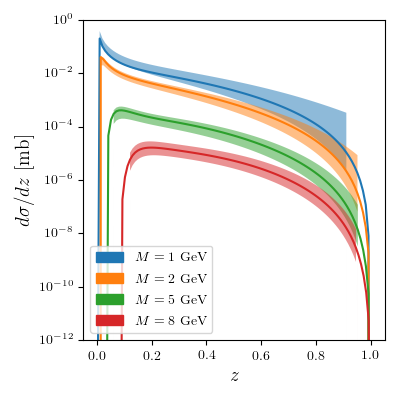

In [20]:
%matplotlib notebook

labels = [Patch(facecolor="C0", edgecolor="C0", label=r"$M=1$ GeV"),
          Patch(facecolor="C1", edgecolor="C1", label=r"$M=2$ GeV"),
          Patch(facecolor="C2", edgecolor="C2", label=r"$M=5$ GeV"),
          Patch(facecolor="C3", edgecolor="C3", label=r"$M=8$ GeV")]

fig, ax = plt.subplots(figsize=(4, 4))

for i, M in enumerate(Ms):

    ax.plot(data["npm"][i]["z"], data["npm"][i]["npm"], color="C{}".format(i), Linestyle='-')
    ax.fill_between(data["nlo"][i]["z"], data["nlo"][i]["inf"], data["nlo"][i]["sup"], color="C{}".format(i), alpha=0.5, Linewidth=0)
    
ax.set(xscale='linear',yscale='log')
ax.set_xlabel(r"$z$", fontsize=14)
ax.set_ylabel(r"$d\sigma/dz$ [mb]", fontsize=14)
ax.set_ylim(bottom=1e-12, top=1e0)

plt.legend(handles=labels, loc="lower left")
plt.tight_layout()